# Foxes vs Rabbits

In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

from westworld.environment import GridEnvironment
from westworld.agents import BaseAgent
from westworld.objects import BaseObstacle,BaseTrigger,BaseCollectible
from westworld.simulation import Simulation
from westworld.colors import *

pygame 2.0.1 (SDL 2.0.14, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


##### Simple rabbits experiments
- Several rabbits who whill look for food and eat what they can find
- Wandering rabbits until they find food they can eat
- Rabbits who look for food and can die if they don't find in time, with collectibles re-appearing over time - param: search strategy
- Rabbits who reproduce over time
- Rabbits who reproduce over time and transmit their search strategy
- Rabbits can be sexier than others
- Rabbits can bear children for longer time for more fitness

##### Introducing foxes
- Adding foxes who can eat rabbit if they find some
- Adding fleeing behavior for rabbits

##### Complex behaviors
- Variable parameters
- Reinforcement Learning

##### Other ideas
- Varying maps with obstacles and quiet zones

# Experiment 1 - Rabbits quietly eating
Grid environments with several rabbits who whill look for food and eat what they can find

##### Defining food

In [8]:
class Food(BaseCollectible):
    def __init__(self,x,y):
        super().__init__(x,y,color = (220,150,50),img_asset = "ball")

##### Defining rabbits

In [9]:
class Rabbit(BaseAgent):
    
    def __init__(self,x,y,curiosity = 5):
        super().__init__(x,y,color = (229, 229, 229),curiosity = curiosity)
    
    def step(self):
        
        # Find closest food
        targets = self.find_closest(name = "Food",k = 1)
        
        # If there is still food, move towards the food
        if len(targets) > 0:
            
            target = targets[0]
            
            # Use naive pathfinding for faster computation as there is no obstacle
            self.move_towards(obj = target,naive = True)
            
        # Otherwise just wandering
        # Changing direction every n steps where n = curiosity
        else:
            self.wander()

##### Preparing environment and simulation

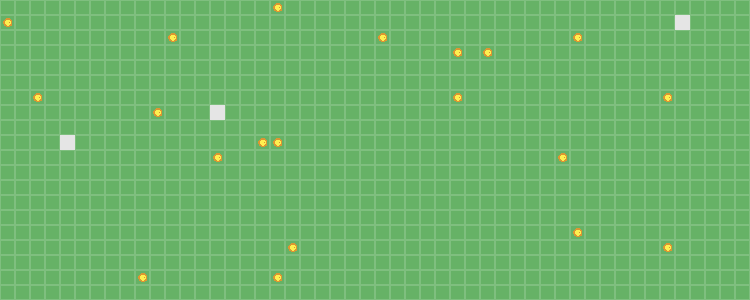

In [10]:
# Setup spawners
rabbit_spawner = lambda x,y : Rabbit(x,y,curiosity = 5)
food_spawner = lambda x,y : Food(x,y)

# Setup environment
env = GridEnvironment(50,20,15,show_grid = True,background_color=(102, 178, 102),grid_color=(127, 191, 127),toroidal=True)
env.spawn(rabbit_spawner,3)
env.spawn(food_spawner,20)
env.render()
env.get_img()

In [11]:
# Setup simulation
sim = Simulation(env,fps = 100,name="RabbitsVsFoxesExperiment1")

In [12]:
sim.run_episode(n_steps = 100,save = False,replay = True)

  0%|          | 0/100 [00:00<?, ?it/s]

interactive(children=(Play(value=0, description='Press play', interval=200), Output()), _dom_classes=('widget-…

IntSlider(value=0)

(0,
 Empty DataFrame
 Columns: []
 Index: [])

# Experiment 2 - Rabbits that have to explore and find food
In this second experiment rabbits don't have the perfect view of the environment, they have a vision range. They will explore and wander in the environment to find food. Once they found one, they move towards it to eat it. 

##### What do we need to add?
- Only finding food in a given range using the ``.find_in_range()`` function instead of ``.find_closest()``
- An attribute to store the next target (otherwise, at each step tick, the rabbit could randomly choose another food than the one it was directed to)
- A visualization of the vision range, with changing colors if the rabbit is looking for food, or if it has found at least one closeby

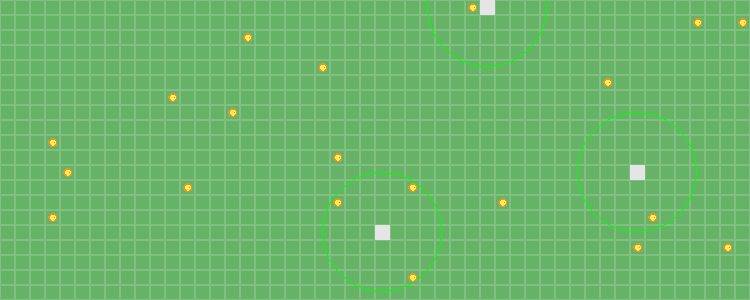

In [74]:
import random

class Rabbit(BaseAgent):
    
    def __init__(self,x,y,curiosity = 5,vision_range = 10,show_range = True):
        super().__init__(x,y,color = (229, 229, 229),curiosity = curiosity)
        self.vision_range = vision_range
        self.show_range = show_range
        self.range_color = GREEN
        
        # Store the food the rabbit was looking for
        self.next_target = None
        
    def postrender(self):
        if self.show_range:
            self.render_circle(radius = self.vision_range,color = self.range_color,thickness = 1)
    
    def step(self):
        
        # Find closest food
        targets = self.find_in_range(name = "Food",radius = self.vision_range)
        
        # If there is food around, move towards the food
        if len(targets) > 0:
            self.range_color = RED
            
            # Choose among targets in range
            # TODO could be optimized to go to the closest one
            # If the rabbit was already looking for a specific piece of food, we go fetch it
            # If the next piece of food is not in range anymore (another rabbit has eaten it), just take another one
            if self.next_target is None or self.next_target not in targets:
                target = random.choice(targets)
                self.next_target = target
            else:
                target = self.next_target
            
            # Use naive pathfinding for faster computation as there is no obstacle
            self.move_towards(obj = target,naive = True)
            
        # Otherwise just wandering
        # Changing direction every n steps where n = curiosity
        else:
            self.range_color = GREEN
            self.wander()
            
            
# Setup spawners
rabbit_spawner = lambda x,y : Rabbit(x,y,curiosity = 5,vision_range = 4)
food_spawner = lambda x,y : Food(x,y)

# Setup environment
env = GridEnvironment(50,20,15,show_grid = True,background_color=(102, 178, 102),grid_color=(127, 191, 127),toroidal=True)
env.spawn(rabbit_spawner,3)
env.spawn(food_spawner,20)
env.render()
env.get_img()

In [75]:
# Setup simulation
sim = Simulation(env,fps = 100,name="RabbitsVsFoxesExperiment2")
sim.run_episode(n_steps = 200,save = False,replay = True)

  0%|          | 0/200 [00:00<?, ?it/s]

interactive(children=(Play(value=0, description='Press play', interval=200, max=200), Output()), _dom_classes=…

IntSlider(value=0, max=200)

0

# Experiment 3 - Rabbits that can die if they don't find food in time
In this 3rd experiments rabbits have to find food before they starve to death. Concretely they have a hunger ticking clock. If it goes to 0, the rabbit dies. If they eat something they survive longer. <br>
Food grows randomly in the environment over time. 

##### What do we need to add?
- A hunger "life", visualized directly on the rabbit
- The behavior of removing the rabbit if it dies
- A collectible callback on the food collection to feed the rabbit
- A random regeneration of food if there are not enough

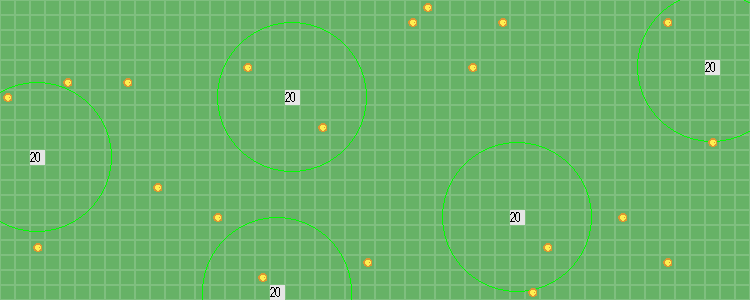

In [76]:
import random

class Food(BaseCollectible):
    def __init__(self,x,y,quantity = 5):
        super().__init__(x,y,color = (220,150,50),img_asset = "ball")
        self.quantity = quantity

    def on_trigger(self,obj):
        obj.life += self.quantity    
        

class Rabbit(BaseAgent):
    
    def __init__(self,x,y,curiosity = 5,vision_range = 10,show_range = True,hunger_resistance = 20):
        super().__init__(x,y,color = (229, 229, 229),curiosity = curiosity)
        self.vision_range = vision_range
        self.show_range = show_range
        self.range_color = GREEN
        
        # Store the food the rabbit was looking for
        self.next_target = None
        
        # Prepare life
        self.life = hunger_resistance
        
    def postrender(self):
        if self.show_range:
            self.render_circle(radius = self.vision_range,color = self.range_color,thickness = 1)
            
        self.render_text(self.life,size = 12,color=(0,0,0))
    
    def step(self):
        
        # Find closest food
        targets = self.find_in_range(name = "Food",radius = self.vision_range)
        
        # If there is food around, move towards the food
        if len(targets) > 0:
            self.range_color = RED
            
            # Choose among targets in range
            # TODO could be optimized to go to the closest one
            # If the rabbit was already looking for a specific piece of food, we go fetch it
            # If the next piece of food is not in range anymore (another rabbit has eaten it), just take another one
            if self.next_target is None or self.next_target not in targets:
                target = random.choice(targets)
                self.next_target = target
            else:
                target = self.next_target
            
            # Use naive pathfinding for faster computation as there is no obstacle
            self.move_towards(obj = target,naive = True)
            
        # Otherwise just wandering
        # Changing direction every n steps where n = curiosity
        else:
            self.range_color = GREEN
            self.wander()
            
        # After each step, the rabbit lose one life unit
        self.life -= 1
        
        # If the rabbit dies we remove it from the environment
        if self.life == 0:
            self.kill()
            
            
class CustomEnvironment(GridEnvironment):
    
    def post_step(self):
        
        if self.clock > 0 and self.clock % 5 == 0:
            self.spawn(food_spawner,4)
            
# Setup spawners
rabbit_spawner = lambda x,y : Rabbit(x,y,curiosity = 5,vision_range = 5)
food_spawner = lambda x,y : Food(x,y,quantity = 10)

# Setup environment
env = CustomEnvironment(50,20,15,show_grid = True,background_color=(102, 178, 102),grid_color=(127, 191, 127),toroidal=True)
env.spawn(rabbit_spawner,5)
env.spawn(food_spawner,20)
env.render()
env.get_img()

In [77]:
# Setup simulation
sim = Simulation(env,fps = 100,name="RabbitsVsFoxesExperiment3")
sim.run_episode(n_steps = 200,save = False,replay = True)

  0%|          | 0/200 [00:00<?, ?it/s]

interactive(children=(Play(value=0, description='Press play', interval=200, max=200), Output()), _dom_classes=…

IntSlider(value=0, max=200)

0

# Experiment 4: reproduction
In this 4th experiment rabbits now have to find mates on top of just finding food. They will switch between looking for each of them filling their basic needs. 

##### What do we need to add?
- Superposition of agents to account for reproduction (ie 2 agents possible at the same case
- A needs bar and selection of each need during actions
- Pregnancy
- Reproduction behavior

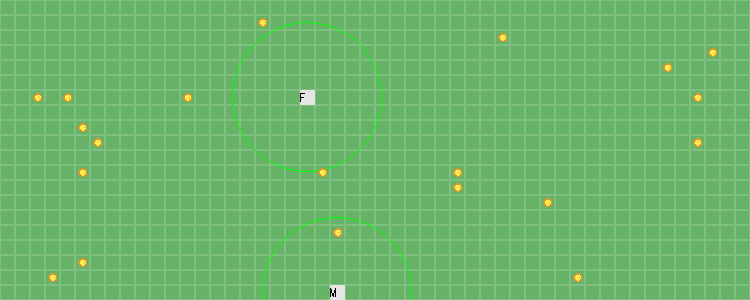

In [10]:
import random
import pygame

class Food(BaseCollectible):
    def __init__(self,x,y,quantity = 5):
        super().__init__(x,y,color = (220,150,50),img_asset = "ball")
        self.quantity = quantity

    def on_trigger(self,obj):
        obj.needs["eating"] = min([100,obj.needs["eating"] + self.quantity])    
        

class Rabbit(BaseAgent):
    
    def __init__(self,x,y,curiosity = 5,vision_range = 10,show_range = True,life = 100,gender = "female"):
        super().__init__(x,y,color = (229, 229, 229),curiosity = curiosity)
        self.vision_range = vision_range
        self.show_range = show_range
        self.range_color = GREEN
        self.original_color = self.color
        self.gender = gender
        self.pregnant = False
        
        assert self.gender in ["female","male"]
        
        
        self.needs = {
            "mating":100,
            "eating":99,
        }
        
        # Store the food and mate the rabbit was looking for
        self.targets = {}
        
        # Prepare life
        self.life = life
        
    @property
    def blocking(self):
        return False
        
    def postrender(self):
        if self.show_range:
            self.render_circle(radius = self.vision_range,color = self.range_color,thickness = 1)
            
        self.render_text(self.gender[0].upper(),size = 12,color=(0,0,0))
        
    
    def find_group(self,**kwargs):
        objs = self.find(**kwargs)
        objs = [x for x in objs if x.id != self.id]
        group = pygame.sprite.Group(objs)
        return group
    
    def collides_with(self,**kwargs):
        group = self.find_group(**kwargs)
        collisions = self.collides_group(group)
        return collisions
    
    def choose_next_target(self,name,options):
        next_target = self.targets.get(name)
        if next_target is None or next_target not in options:
            target = random.choice(options)
            self.targets[name] = target
        else:
            target = next_target
        return target
    
    
    def mates_with(self,other):
        
        # This condition avoids double counting in the step loop and having more than 2 parents mating
        if self.needs["mating"] < 100 and other.needs["mating"] < 100:
        
            # Fill each other needs
            self.needs["mating"] = 100
            other.needs["mating"] = 100

            # Getting pregnant
            female = self if self.gender == "female" else other
            female.pregnant = True
            female.starts_counting("pregnancy")

            
    def gives_birth(self):
        
        n = 3
        for i in range(3):
            
            gender = random.choice(["female","male"])
            child = Rabbit(self.x,self.y,curiosity = 5,vision_range = 5,gender = gender)
            self.env.add_object(child)
            
        self.pregnant = False
        
    
    def step(self):
        
        if self.pregnant and self.counter("pregnancy") < 7:
            self.color = RED
        else:
            self.color = self.original_color
        
        #---------------------------------------------------------------------
        # GIVING BIRTH
        
        if self.pregnant and self.counter("pregnancy") == 7:
            self.gives_birth()
        
        #---------------------------------------------------------------------
        # REPRODUCTION
        
        elif self.needs["mating"] < self.needs["eating"] and not self.pregnant:


            other_gender = "female" if self.gender == "male" else "male"
            mates = self.find_in_range(name = "Rabbit",gender = other_gender,pregnant = False,radius = self.vision_range)

            if len(mates) > 0:
                self.range_color = RED
                target_mate = self.choose_next_target("mate",mates)
                self.move_towards(obj = target_mate,naive = True)
            else:
                self.range_color = GREEN
                self.wander()

            collisions = self.collides_with(name="Rabbit",gender = other_gender)
            if len(collisions) > 0:
                mate = collisions[0]
                self.mates_with(mate)
        
        #---------------------------------------------------------------------
        # EATING
        
        else:

            # Find closest food
            targets_food = self.find_in_range(name = "Food",radius = self.vision_range)

            # If there is food around, move towards the food
            if len(targets_food) > 0:
                self.range_color = RED

                # Choose among targets in range
                # TODO could be optimized to go to the closest one
                # If the rabbit was already looking for a specific piece of food, we go fetch it
                # If the next piece of food is not in range anymore (another rabbit has eaten it), just take another one
                target_food = self.choose_next_target("food",targets_food)

                # Use naive pathfinding for faster computation as there is no obstacle
                self.move_towards(obj = target_food,naive = True)

            # Otherwise just wandering
            # Changing direction every n steps where n = curiosity
            else:
                self.range_color = GREEN
                self.wander()
            
            
        #---------------------------------------------------------------------
        # AGING
        
        # Increase for each counter steps
        self.counter_step()
        
        # After each step, the rabbit lose one life unit and get more hungry
        self.life -= 1
        self.needs["eating"] -= 1
        self.needs["mating"] -= 1
        
        # If the rabbit dies we remove it from the environment
        if self.life == 0:
            self.kill()
            
        # If the rabbit starved we also remove it
        if self.needs["eating"] <= 0:
            self.kill()
            
        #---------------------------------------------------------------------
        # LOGGING
        
        self.log({
            "life":self.life,
            "eating":self.needs["eating"],
            "mating":self.needs["mating"],
            "gender":self.gender,
        })
            
            
class CustomEnvironment(GridEnvironment):
    
    def post_step(self):
        
        food_left = self.find(name = "Food")
        self.log({"food_left":len(food_left)})
        
        if self.clock > 0 and self.clock % 5 == 0:
            self.spawn(food_spawner,4)
            
# Setup spawners
male_spawner = lambda x,y : Rabbit(x,y,curiosity = 5,vision_range = 5,gender = "male")
female_spawner = lambda x,y : Rabbit(x,y,curiosity = 5,vision_range = 5,gender = "female")
food_spawner = lambda x,y : Food(x,y,quantity = 10)

# Setup environment
env = CustomEnvironment(50,20,15,show_grid = True,background_color=(102, 178, 102),grid_color=(127, 191, 127),toroidal=True)
env.spawn(male_spawner,1)
env.spawn(female_spawner,1)
env.spawn(food_spawner,20)
env.render()
env.get_img()

In [11]:
# Setup simulation
sim = Simulation(env,fps = 200,name="RabbitsVsFoxesExperiment4")
_,episode_data = sim.run_episode(n_steps = 200,save = False,replay = True)

  0%|          | 0/200 [00:00<?, ?it/s]

interactive(children=(Play(value=0, description='Press play', interval=200, max=200), Output()), _dom_classes=…

IntSlider(value=0, max=200)

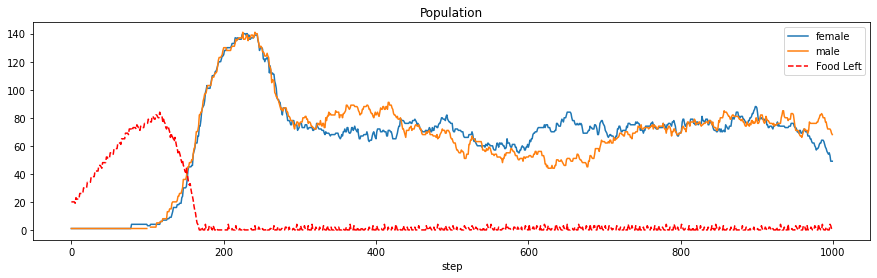

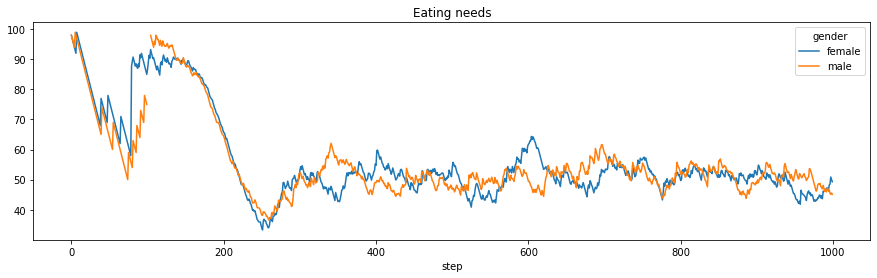

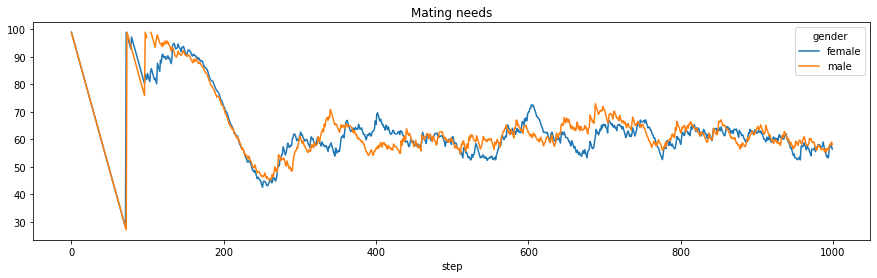

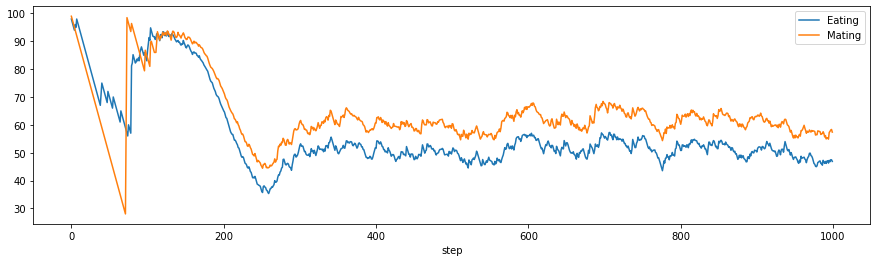

In [86]:
episode_data.groupby(["step","gender"])["life"].count().unstack("gender").plot(figsize = (15,4),title = "Population")
episode_data.groupby(["step"])["food_left"].sum().plot(label = "Food Left",color = "red",style = "--")
plt.legend()
plt.show


episode_data.groupby(["step","gender"])["eating"].mean().unstack("gender").plot(figsize = (15,4),title = "Eating needs")
plt.show()

episode_data.groupby(["step","gender"])["mating"].mean().unstack("gender").plot(figsize = (15,4),title = "Mating needs")
plt.show()

episode_data.groupby(["step"])["eating"].mean().plot(figsize = (15,4),label = "Eating")
episode_data.groupby(["step"])["mating"].mean().plot(label = "Mating")
plt.legend()
plt.show()

## Experiment 5 - Reproduction & Genetic algorithms

In [4]:
from westworld.algorithms.genetic import Gene,DNA

dna = DNA([
    Gene("curiosity",value_range = [2,20],type = "int"),
    Gene("vision_range",value_range = [5,50],type = "int"),
    Gene("needs_mating_step",value_range = [0.01,2],type = "float"),
    Gene("needs_eating_step",value_range = [1,2],type = "float"),
    Gene("pregnancy",value_range = [20,50],type = "int"),
#     + max_life ? 
])

dna

DNA(curiosity=10.000,vision_range=8.000,needs_mating_step=0.272,needs_eating_step=1.581,pregnancy=38.000)

In [6]:
dna1 = dna.sample()
dna2 = dna.sample()

In [7]:
dna1

DNA(curiosity=17.000,vision_range=5.000,needs_mating_step=1.231,needs_eating_step=1.645,pregnancy=34.000)

In [8]:
dna2 

DNA(curiosity=14.000,vision_range=50.000,needs_mating_step=0.071,needs_eating_step=1.111,pregnancy=46.000)

In [9]:
dna3 = dna1.mate(dna2)

In [10]:
dna3

DNA(curiosity=15.000,vision_range=22.000,needs_mating_step=0.265,needs_eating_step=1.268,pregnancy=43.000)

In [11]:
dna3.sample()

DNA(curiosity=12.000,vision_range=25.000,needs_mating_step=1.807,needs_eating_step=1.067,pregnancy=48.000)

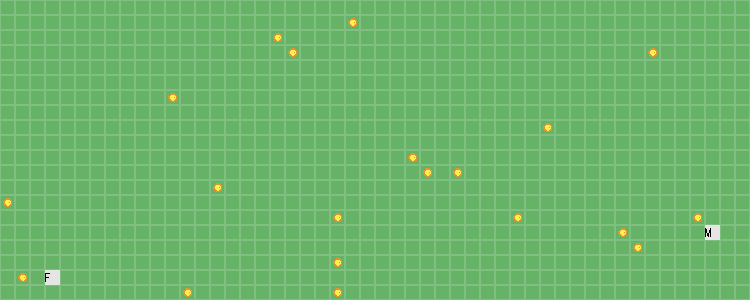

In [14]:
import random
import pygame

class Food(BaseCollectible):
    def __init__(self,x,y,quantity = 20):
        super().__init__(x,y,color = (220,150,50),img_asset = "ball")
        self.quantity = quantity

    def on_trigger(self,obj):
        obj.needs["eating"] = min([100,obj.needs["eating"] + self.quantity])    

        


class Rabbit(BaseAgent):
    
    def __init__(self,x,y,dna,show_range = True,life = 100,gender = "female"):
        
        
        self.dna = dna
        self.curiosity = dna.get("curiosity")
        self.vision_range = dna.get("vision_range")
        self.pregnancy = dna.get("pregnancy")
        
        super().__init__(x,y,color = (229, 229, 229),curiosity = self.curiosity)
        self.show_range = show_range
        self.range_color = GREEN
        self.original_color = self.color
        self.gender = gender
        self.pregnant = False
        
        assert self.gender in ["female","male"]
        
        
        self.needs = {
            "mating":100,
            "eating":99,
        }
        
        # Store the food and mate the rabbit was looking for
        self.targets = {}
        
        # Prepare life
        self.life = life
        
    @property
    def blocking(self):
        return False
        
    def postrender(self):
#         if self.show_range:
#             self.render_circle(radius = self.vision_range,color = self.range_color,thickness = 1)
            
        self.render_text(self.gender[0].upper(),size = 12,color=(0,0,0))
        
    
    def find_group(self,**kwargs):
        objs = self.find(**kwargs)
        objs = [x for x in objs if x.id != self.id]
        group = pygame.sprite.Group(objs)
        return group
    
    def collides_with(self,**kwargs):
        group = self.find_group(**kwargs)
        collisions = self.collides_group(group)
        return collisions
    
    def choose_next_target(self,name,options):
        next_target = self.targets.get(name)
        if next_target is None or next_target not in options:
            target = random.choice(options)
            self.targets[name] = target
        else:
            target = next_target
        return target
    
    
    def mates_with(self,other):
        
        # This condition avoids double counting in the step loop and having more than 2 parents mating
        if self.needs["mating"] < 100 and other.needs["mating"] < 100:
        
            # Fill each other needs
            self.needs["mating"] = 100
            other.needs["mating"] = 100

            # Getting pregnant
            female = self if self.gender == "female" else other
            female.pregnant = True
            female.children_dna = [self.dna,other.dna]
            female.starts_counting("pregnancy")

            
    def gives_birth(self):
        
        n = 3
        for i in range(3):
            
            gender = random.choice(["female","male"])
            child = Rabbit(self.x,self.y,self.children_dna[0].mate(self.children_dna[1]),gender = gender)
            self.env.add_object(child)
            
        self.pregnant = False
        
    
    def step(self):
        
        if self.pregnant and self.counter("pregnancy") < self.pregnancy:
            self.color = RED
        else:
            self.color = self.original_color
        
        #---------------------------------------------------------------------
        # GIVING BIRTH
        
        if self.pregnant and self.counter("pregnancy") == self.pregnancy:
            self.gives_birth()
        
        #---------------------------------------------------------------------
        # REPRODUCTION
        
        elif self.needs["mating"] < self.needs["eating"] and not self.pregnant:


            other_gender = "female" if self.gender == "male" else "male"
            mates = self.find_in_range(name = "Rabbit",gender = other_gender,pregnant = False,radius = self.vision_range)

            if len(mates) > 0:
                self.range_color = RED
                target_mate = self.choose_next_target("mate",mates)
                self.move_towards(obj = target_mate,naive = True)
            else:
                self.range_color = GREEN
                self.wander()

            collisions = self.collides_with(name="Rabbit",gender = other_gender)
            if len(collisions) > 0:
                mate = collisions[0]
                self.mates_with(mate)
        
        #---------------------------------------------------------------------
        # EATING
        
        else:

            # Find closest food
            targets_food = self.find_in_range(name = "Food",radius = self.vision_range)

            # If there is food around, move towards the food
            if len(targets_food) > 0:
                self.range_color = RED

                # Choose among targets in range
                # TODO could be optimized to go to the closest one
                # If the rabbit was already looking for a specific piece of food, we go fetch it
                # If the next piece of food is not in range anymore (another rabbit has eaten it), just take another one
                target_food = self.choose_next_target("food",targets_food)

                # Use naive pathfinding for faster computation as there is no obstacle
                self.move_towards(obj = target_food,naive = True)

            # Otherwise just wandering
            # Changing direction every n steps where n = curiosity
            else:
                self.range_color = GREEN
                self.wander()
            
            
        #---------------------------------------------------------------------
        # AGING
        
        # Increase for each counter steps
        self.counter_step()
        
        # After each step, the rabbit lose one life unit and get more hungry
        self.life -= 1
        self.needs["eating"] -= self.dna.get("needs_eating_step")
        self.needs["mating"] -= self.dna.get("needs_mating_step")
        
        # If the rabbit dies we remove it from the environment
        if self.life == 0:
            self.kill()
            
        # If the rabbit starved we also remove it
        if self.needs["eating"] <= 0:
            self.kill()
            
        #---------------------------------------------------------------------
        # LOGGING
        
        self.log({
            "life":self.life,
            "eating":self.needs["eating"],
            "mating":self.needs["mating"],
            "gender":self.gender,
            "curiosity":self.dna["curiosity"].value,
            "vision_range":self.dna["vision_range"].value,
            "pregnancy":self.dna["pregnancy"].value,
            "needs_mating_step":self.dna["needs_mating_step"].value,
            "needs_eating_step":self.dna["needs_eating_step"].value,
        })
            
            
class CustomEnvironment(GridEnvironment):
    
    def post_step(self):
        
        food_left = self.find(name = "Food")
        self.log({"food_left":len(food_left)})
        
        if self.clock > 0 and self.clock % 5 == 0:
            self.spawn(food_spawner,4)
            
# Setup spawners
male_spawner = lambda x,y : Rabbit(x,y,dna.sample(),gender = "male")
female_spawner = lambda x,y : Rabbit(x,y,dna.sample(),gender = "female")
food_spawner = lambda x,y : Food(x,y,quantity = 10)

# Setup environment
env = CustomEnvironment(50,20,15,show_grid = True,background_color=(102, 178, 102),grid_color=(127, 191, 127),toroidal=True)
env.spawn(male_spawner,1)
env.spawn(female_spawner,1)
env.spawn(food_spawner,20)
env.render()
env.get_img()

In [15]:
# Setup simulation
sim = Simulation(env,fps = 200,name="RabbitsVsFoxesExperiment4")
_,episode_data = sim.run_episode(n_steps = 3000,save = False,replay = True,fps_replay = 25)

  0%|          | 0/3000 [00:00<?, ?it/s]

interactive(children=(Play(value=0, description='Press play', interval=40, max=2161), Output()), _dom_classes=…

IntSlider(value=0, max=2161)

In [52]:
episode_data

,step,id,life,eating,mating,gender,curiosity,vision_range,pregnancy,needs_mating_step,needs_eating_step,food_left
0,0,40e26501-2395-11ec-8ed6-646ee09040ec,99.0,97.159281,98.160099,male,15.0,42.0,48.0,1.839901,1.840719,NaN
1,0,40e28c14-2395-11ec-9f79-646ee09040ec,99.0,97.985908,99.556220,female,5.0,43.0,22.0,0.443780,1.014092,NaN
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0
3,1,40e26501-2395-11ec-8ed6-646ee09040ec,98.0,95.318563,96.320198,male,15.0,42.0,48.0,1.839901,1.840719,NaN
4,1,40e28c14-2395-11ec-9f79-646ee09040ec,98.0,96.971816,99.112440,female,5.0,43.0,22.0,0.443780,1.014092,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
53296,2995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233.0
53297,2996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,237.0
53298,2997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,237.0
53299,2998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,237.0


In [17]:
episode_data.dropna(subset = ["needs_eating_step"])

,step,id,life,eating,mating,gender,curiosity,vision_range,pregnancy,needs_mating_step,needs_eating_step,food_left
0,0,ea442751-23a7-11ec-9fa9-646ee09040ec,99.0,97.413652,98.348565,male,17.0,42.0,21.0,1.651435,1.586348,NaN
1,0,ea448239-23a7-11ec-b991-646ee09040ec,99.0,97.069617,99.507260,female,20.0,41.0,21.0,0.492740,1.930383,NaN
3,1,ea442751-23a7-11ec-9fa9-646ee09040ec,98.0,98.413652,96.697131,male,17.0,42.0,21.0,1.651435,1.586348,NaN
4,1,ea448239-23a7-11ec-b991-646ee09040ec,98.0,95.139234,99.014521,female,20.0,41.0,21.0,0.492740,1.930383,NaN
6,2,ea442751-23a7-11ec-9fa9-646ee09040ec,97.0,96.827304,95.045696,male,17.0,42.0,21.0,1.651435,1.586348,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
49817,1913,06755737-23a8-11ec-a76f-646ee09040ec,4.0,2.718372,-57.641987,male,19.0,41.0,21.0,1.642104,1.732100,NaN
49819,1914,06755737-23a8-11ec-a76f-646ee09040ec,3.0,10.986272,-59.284091,male,19.0,41.0,21.0,1.642104,1.732100,NaN
49821,1915,06755737-23a8-11ec-a76f-646ee09040ec,2.0,9.254172,-60.926195,male,19.0,41.0,21.0,1.642104,1.732100,NaN
49823,1916,06755737-23a8-11ec-a76f-646ee09040ec,1.0,17.522071,-62.568299,male,19.0,41.0,21.0,1.642104,1.732100,NaN


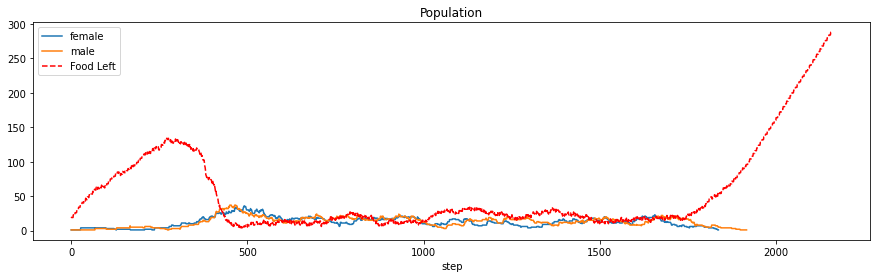

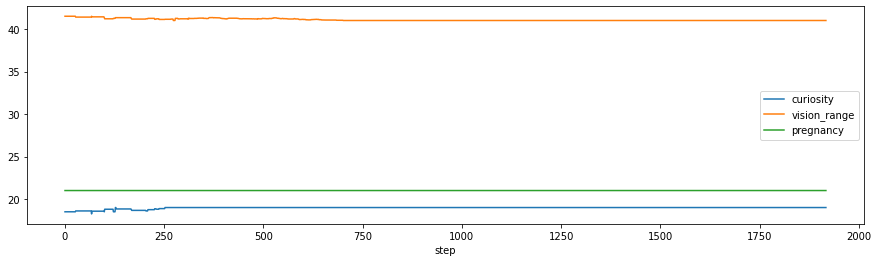

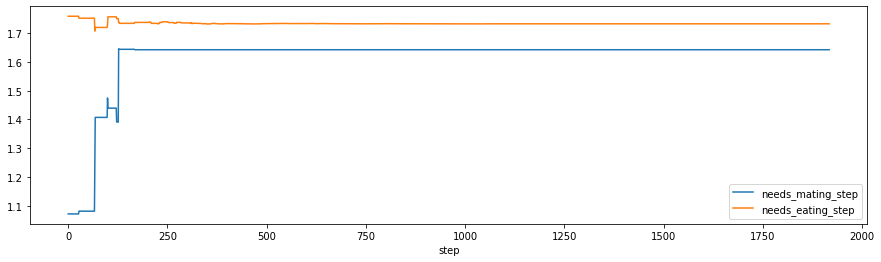

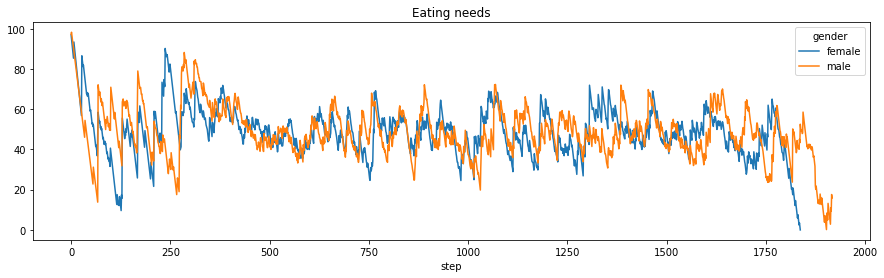

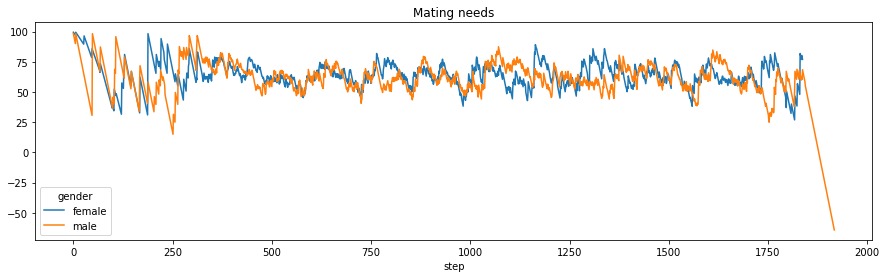

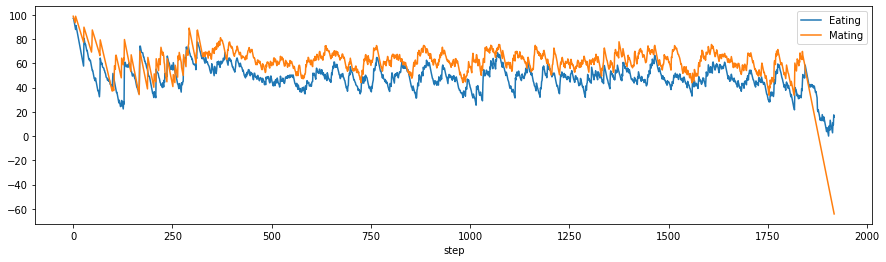

In [16]:
episode_data.groupby(["step","gender"])["life"].count().unstack("gender").plot(figsize = (15,4),title = "Population")
episode_data.groupby(["step"])["food_left"].sum().plot(label = "Food Left",color = "red",style = "--")
plt.legend()
plt.show()

episode_data.groupby(["step"])["curiosity"].mean().plot(figsize = (15,4));
episode_data.groupby(["step"])["vision_range"].mean().plot(figsize = (15,4));
episode_data.groupby(["step"])["pregnancy"].mean().plot(figsize = (15,4));
plt.legend()
plt.show()

episode_data.groupby(["step"])["needs_mating_step"].mean().plot(figsize = (15,4));
episode_data.groupby(["step"])["needs_eating_step"].mean().plot(figsize = (15,4));
plt.legend()
plt.show()


episode_data.groupby(["step","gender"])["eating"].mean().unstack("gender").plot(figsize = (15,4),title = "Eating needs")
plt.show()

episode_data.groupby(["step","gender"])["mating"].mean().unstack("gender").plot(figsize = (15,4),title = "Mating needs")
plt.show()

episode_data.groupby(["step"])["eating"].mean().plot(figsize = (15,4),label = "Eating")
episode_data.groupby(["step"])["mating"].mean().plot(label = "Mating")
plt.legend()
plt.show()